# Build a Customer Support Bot

1. In this tutorial, you will build a customer support bot for an airline to help users research and make travel arrangements:
    - organize your assistant's tools
    - manage a user's flight bookings
    - hotel reservations
    - car rentals
    - excursions
2. Techs including 
    - LangGraph's interrupts
    - checkpointers
    - more complex state
3. By this tutorial, you'll have gained an understanding of LangGraph's key concepts and architectures.

4. Your final chat bot will look something like the following diagram:
- <a href="https://langchain-ai.github.io/langgraph/tutorials/customer-support/img/part-4-diagram.png">
  <img src="https://langchain-ai.github.io/langgraph/tutorials/customer-support/img/part-4-diagram.png" alt="描述文字" width="300">
</a>

# 1. Prerequisites

## 1. Set Up
1. Install this tutorial's prerequisites
2. Download the test DB
3. define the tools we will reuse in each section.
4. **DeepSeek** is our chosen LLM.
5. Most of our tools will connect to a local sqlite database
6. A general web search to the agent using Tavily

In [3]:
# capture: Captures all output from the cell (standard output and standard error).
# --no-stderr: Do not capture the standard error, only capture the standard output.
%%capture --no-stderr
%pip install -U langgraph langchain-community tavily-python pandas openai langchain_deepseek

In [4]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


_set_env("DEEPSEEK_API_KEY")
_set_env("TAVILY_API_KEY")

DEEPSEEK_API_KEY:  ········
TAVILY_API_KEY:  ········


## 2. Populate the database
- Run below SQL to fetch a sqlite DB prepared for this tutorial.

- 目标：下载一个 SQLite 数据库文件，并将数据库中的日期时间字段更新到当前时间（基于某个时间差）。
- 逻辑：
1. 定义变量
2. 下载SQL数据库文件，检查连接状态
3. 将文件写入到文件夹中
4. 备份本地文件

4. 创建update_date函数，更新日期到最新
5. 将备份文件写入到local_file中
6. 连接上面的数据库文件，创建查询对象，用来进行数据库查询操作，这一步返回一个查询类型的对象
    - conn = sqlite3.Connection
7. 查询类型的对象有cursor的方法，能够实例化出一个cursur出来,这个cursor是一个操作数据库的工具，需要实例化成具体的对象后才能发挥作用。
    - sqlite3.Cursor
8. 发送sql字符串代码，从文件中读取表名数据，将读到的数据对象的名称编程一个todo list
    - pd.read_sql pd是一个模块对象，read_sql是一个方法对象，参数是一个字符串对象，返回了什么对象？
        - pandas.DataFrame
    - conn参数的作用是什么？ 数据库配置信息
    - .name拿到了对象的名称？ 结果也是一个对象？具体是什么
        - pandas.Series
        - 从查询结果（sqlite_master 表）的 "name" 列取值（表名）。  
        - Series 是一个一维带标签的数组对象。
    - .todolist()的方法结果是什么？生成了一个什么对象？
        - list
9. 创建一个字典对象tdf，存储表名和对应的数据
10. 对于for循环，队医每个表名，读取其数据内容，将表内容生成dataframe对象，存储在上述字典中。
    - tdf[t] = DataFrame字典的键更改操作，将得到的dataframe类型对象赋值到这个键对应的值上
11. 取出actual_departure列-series对象，将列的内容替换为pd.Nat,得到一个series对象，将这个series的元素转换成datetime类型，输出仍然是series，然后用max函数计算出最大值，输出一个pandas.Timestamp类型对象。

12. 获取系统时间(timestamp)，获得取得的模版时间的时区信息（pytz.tzinfo）作为模版时区参数，给获得的系统时间增加时区信息并输出结果（pandas.Timestamp）
13. 计算时差，使用系统当前数据减去模版数据，就是时差了，是timestamp的减法应用，输出类型是pandas.Timedelta
14. 更改字典中“book_date”的值(series)，取出值之后，处理空值（series），转换成datetime格式（series），加上时差（pandas.Timedelta），最后将最终值赋值给book_date（series）
15. 创建一个datetime_columns列表
16. 对于列表中的每一个字符串元素，都有：
    1. floghts表的列表中列出的列，都处理它们的空值，再加上时差，再处理成时间格式（datetime in series），最后替换回去，完成整张表的处理。
17. 拿出tdf字典中所有的元素，对于每一行的键与值有：
    1. to_sql，将所有的内存中的表名对应的表内容写回数据库，有一样的表就替代掉。
18. 清除内存中的所有变量名df及tdf
19. to_sql是暂存的，commit提交事物，.close()关闭 conn（sqlite3.Connection 对象）与数据库文件的连接，释放资源。

In [4]:
import os
import shutil
import sqlite3

import pandas as pd
import requests

db_url = "https://storage.googleapis.com/benchmarks-artifacts/travel-db/travel2.sqlite"
local_file = "travel2.sqlite"
# The backup lets us restart for each tutorial section
backup_file = "travel2.backup.sqlite"
overwrite = False
if overwrite or not os.path.exists(local_file):
    response = requests.get(db_url)
    response.raise_for_status()  # Ensure the request was successful
    with open(local_file, "wb") as f:
        f.write(response.content)
    # Backup - we will use this to "reset" our DB in each section
    shutil.copy(local_file, backup_file)


# Convert the flights to present time for our tutorial
def update_dates(file):
    shutil.copy(backup_file, file)
    conn = sqlite3.connect(file)
    cursor = conn.cursor()

    tables = pd.read_sql(
        "SELECT name FROM sqlite_master WHERE type='table';", conn
    ).name.tolist()
    tdf = {}
    for t in tables:
        tdf[t] = pd.read_sql(f"SELECT * from {t}", conn)

    example_time = pd.to_datetime(
        tdf["flights"]["actual_departure"].replace("\\N", pd.NaT)
    ).max()
    current_time = pd.to_datetime("now").tz_localize(example_time.tz)
    time_diff = current_time - example_time

    tdf["bookings"]["book_date"] = (
        pd.to_datetime(tdf["bookings"]["book_date"].replace("\\N", pd.NaT), utc=True)
        + time_diff
    )

    datetime_columns = [
        "scheduled_departure",
        "scheduled_arrival",
        "actual_departure",
        "actual_arrival",
    ]
    for column in datetime_columns:
        tdf["flights"][column] = (
            pd.to_datetime(tdf["flights"][column].replace("\\N", pd.NaT)) + time_diff
        )

    for table_name, df in tdf.items():
        df.to_sql(table_name, conn, if_exists="replace", index=False)
    del df
    del tdf
    conn.commit()
    conn.close()

    return file


db = update_dates(local_file)

In [2]:
import os
print(os.getcwd())

/Users/zhengchengsheng/artificial_intelligence/ai_skills/langgraph


In [3]:
import os
new_path = "/Users/zhengchengsheng/artificial_intelligence/ai_skills/langgraph/5.build_a_customer_support_bot"
os.chdir(new_path)
print("Updated working directory:", os.getcwd())

Updated working directory: /Users/zhengchengsheng/artificial_intelligence/ai_skills/langgraph/5.build_a_customer_support_bot


# 2. Tools
- Lookup Company Policies
- Flights
- Car Rental Tools
- Hotels
- Excursions
- Utilities
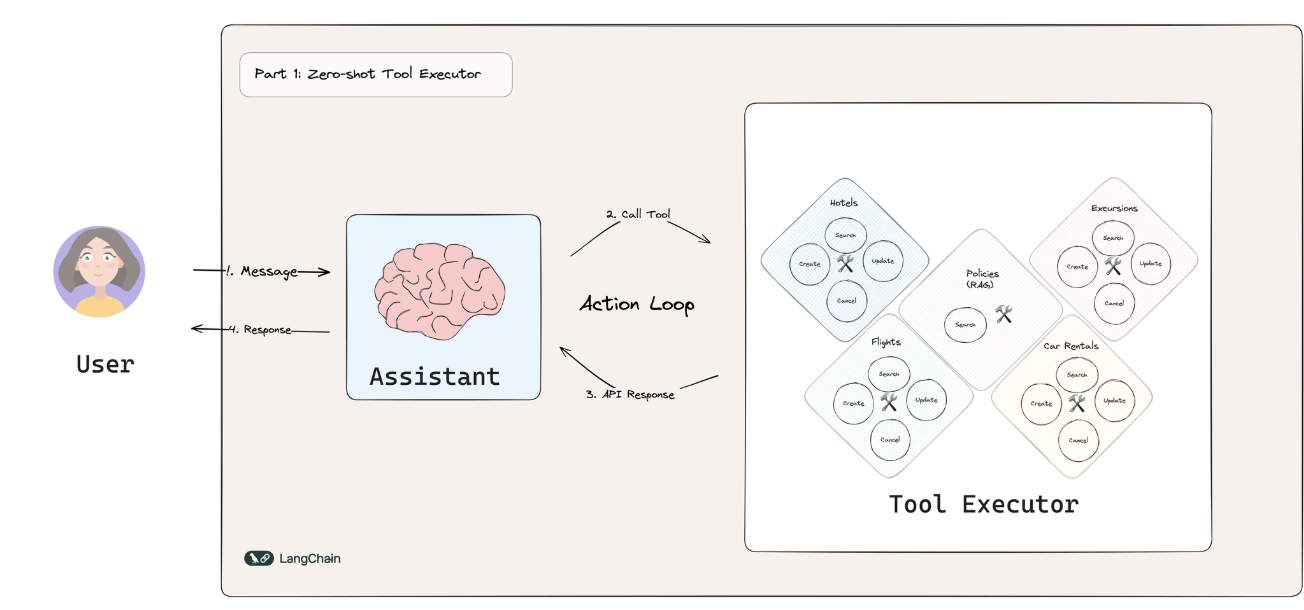

## Lookup Company Policies
- The assistant retrieve policy information to answer user questions. Note that enforcement of these policies still must be done within the tools/APIs themselves, since the LLM can always ignore this.

1. requests.get拿到url
2. raise_for_status检查 HTTP 请求是否成功
3. 请求成功则输出response.text的部分，是一个str对象
    - 这里拿到了从网站拿到的company policy内容
4. 对拿到文章的内容进行字符串分割，将分割的每一段赋值给一个自定义字典的键，形成一个字典组成的列表，里面包含了文章的所有段落。
re.split(r"(?=\n##)", faq_text)

5. 定义一个新的类，这个类用来做向量存储检索任务
    1. 定义初始函数，用于初始化类的实例
      - 用于初始化类的实例，设置初始状态，绑定属性
    2. 定义from_docs函数对象，接收三个参数：cls，docs，oai_client
      1. 将doc列表的内容循环给到embedding model，让这个model生成对应的向量结果，最终输出什么类型的对象？CreateEmbeddingResponse，里面包含data属性。
      2. 但是这里使用的嵌入模型需要openai的付费，自己搭建又需要内存，自己的电脑肯定不太行啊。
      3. 把data的内容拿出来组成向量列表
      4. 最终返回原文档、向量列表、模型，实例化这三个数据到具体的对象中。
    5. 定义 query函数
        1. 将input进行向量化
        2. 将input向量化的结果进行数组化，然后和文档向量的转置结果进行点积，计算出问题与答案的相关性
        3. 相关性最大的前五的索引，这里从倒数第五开始算起
        4. scores是什么类型的对象？是一个数组对象，里面包含了分数。
            - 下一步是从这个分数里拿到最大的5个分数，然后返回她们在scores中的索引，这个时候是乱序的，我们想要把这个弄成分数从大到小分数降序的索引列。
            - 拿到这些索引对应的分数，然后使用负号，再对她们进行升序，拿到升序结果分数所对应的索引值。
            - 最后，根据拿到的索引数字，这个所以是分数的排序结果的索引，所以根据这个顺序出来的索引，就是分数从大到小的索引值。
        5. 最后循环返回每个索引值所对应的文档片段和分数值的内容。
        6. 最后对整个类进行实例化
6. 定义lookup_policy函数，参数是query字符串
    - 调用retriever的query方法，k=2
    - 结果就会有相关性最高的2个片段及相应的分数
    - 这个函数最终将这两个片段的内容循环打印出来，使用join连接在一起

7. 总结：
    - 整体的思路是，下载md文档，将文档进行分割处理成字典保存
    - 来把文档处理成嵌入式，方便检索信息
    - 处理检索逻辑，将问题也向量化，找出最相关的片段
    - 最终输出结果，将结果整合在一起

现在找到方法了，先把原文里面的步骤列出来，然后看怎么替换：
1. import openai
2. openai.Client()
3. oai_client.embeddings.create（ model="text-embedding-3-small", input=[doc["page_content"] for doc in docs]）

In [24]:
import os
import getpass
if not os.getenv("DASHSCOPE_API_KEY"):
    os.environ["DASHSCOPE_API_KEY"] = getpass.getpass("API key: ")

API key:  ········


In [36]:
import re

import numpy as np
import openai
from langchain_core.tools import tool

response = requests.get(
    "https://storage.googleapis.com/benchmarks-artifacts/travel-db/swiss_faq.md"
)
response.raise_for_status()
faq_text = response.text

docs = [{"page_content": txt} for txt in re.split(r"(?=\n##)", faq_text)]


class VectorStoreRetriever:
    def __init__(self, docs: list, vectors: list, oai_client):
        self._arr = np.array(vectors)
        self._docs = docs
        self._client = oai_client

    @classmethod
    def from_docs(cls, docs, oai_client):
        embeddings = oai_client.embeddings.create(
            model="text-embedding-v3", input=[doc["page_content"] for doc in docs],dimensions=1024,
        )
        vectors = [emb.embedding for emb in embeddings.data]
        return cls(docs, vectors, oai_client)

    def query(self, query: str, k: int = 5) -> list[dict]:
        embed = self._client.embeddings.create(
            model="text-embedding-3-small", input=[query]
        )
        # "@" is just a matrix multiplication in python
        scores = np.array(embed.data[0].embedding) @ self._arr.T
        top_k_idx = np.argpartition(scores, -k)[-k:]
        top_k_idx_sorted = top_k_idx[np.argsort(-scores[top_k_idx])]
        return [
            {**self._docs[idx], "similarity": scores[idx]} for idx in top_k_idx_sorted
        ]

client = OpenAI(
    api_key=os.getenv("DASHSCOPE_API_KEY"),  # 如果您没有配置环境变量，请在此处用您的API Key进行替换
    base_url="https://dashscope.aliyuncs.com/compatible-mode/v1"  # 百炼服务的base_url
)
retriever = VectorStoreRetriever.from_docs(docs, client)


@tool
def lookup_policy(query: str) -> str:
    """Consult the company policies to check whether certain options are permitted.
    Use this before making any flight changes performing other 'write' events."""
    docs = retriever.query(query, k=2)
    return "\n\n".join([doc["page_content"] for doc in docs])

In [12]:
print(type(faq_text))

<class 'str'>


In [ ]:
print(dir(response))

In [17]:
print("\n".join(faq_text.splitlines()[:10]))

## Invoice Questions

1. Can I receive an invoice for my booked flight?

Yes, we can send you a new booking confirmation free of charge for up to 100 days after the ticket/document has been completely used. A fee of CHF 30.00 per transaction (maximum of five E-ticket confirmations) will be charged after these 100 days. The E-ticket can be used for invoicing purposes.

2. Do I need to reconfirm my flight?

No, reconfirmation of SWISS flights is not required.



## Flights

- 

## Car Rental Tools
- 定义《fetch_user_flight_information》工具来让代理看到当前用户的航班信息。然后定义工具来搜索航班以整理成歌在sql数据库里面的订单。
- 我们然后可以接入到《RunnableConfig》来跑一下程序，检查接入到这个app的乘客的《passenger_id》，大模型从来不需要明确地提供这些信息，一般都是由图的调用来提供，这样每个用户就没办法看到其他客户的订购信息了。 

In [38]:
pip show langchain-core

Name: langchain-core
Version: 0.3.51
Summary: Building applications with LLMs through composability
Home-page: 
Author: 
Author-email: 
License: MIT
Location: /Users/zhengchengsheng/opt/anaconda3/envs/new_env/lib/python3.12/site-packages
Requires: jsonpatch, langsmith, packaging, pydantic, PyYAML, tenacity, typing-extensions
Required-by: langchain, langchain-anthropic, langchain-community, langchain-deepseek, langchain-fireworks, langchain-openai, langchain-text-splitters, langgraph, langgraph-api, langgraph-checkpoint, langgraph-prebuilt
Note: you may need to restart the kernel to use updated packages.


- 代码框架及逻辑梳理：
1. fetch_user_flight_information
    1. **作用**：
        1. 为用户拿到所有的机票信息，同时确认航班信息以及座位分配情况。
        2. 返回一个字典列表，字典包含机票信息，航班信息以及座位分配情况，这个用户的所有机票的这些信息。
    2. **参数**：config: RunnableConfig（参数为config，是一个RunnableConfig类对象）
    3. **过程**
        1. configuration = config.get("configurable", {})
            - 取到configurable字典的内容，如果不存在就返回一个空字典。
            - 这里的.get()是RunnableConfig对象的自己定义的.get()
        2. passenger_id = configuration.get("passenger_id", None)
            - 从上面获得的字典中取出键为passenger_id的值，应该是一个字符串或者数字，这里只有一个结果值输出
            - 这里的.get()是字典对象自己的.get()方法，用于根据字典的键获取对应的值内容。
        3. if not passenger_id:（如果passenger_id不存在就报错）
        4. conn = sqlite3.connect(db)，连接之前下载好的数据库文件，这里使用sqlite3对象做好连接配置，生成一个配置对象，里面包含了配置信息，以及数据查询的方法，可以直接使用这个对象的方法操作数据库。
        5. cursor = conn.cursor()，使用conn对象的cursor方法，创建一个游标对象，这个游标对象用来执行数据查询的具体操作，conn配置对象只提供工具，不直接执行各种操作。
        6. query = """，构建一个sql语句，用来查询数据
        7. cursor.execute(query, (passenger_id,))， 使用cursor对象的execute方法来接收sql代码和sql语句中where的参数，这里一般使用?来做占位符。这里返回生成查询结果到数据库内存以及cursor对象中。
        8. rows = cursor.fetchall()，取出刚才查询的具体数据结果，结果是一个列表，列表的内容是一个元组，元组是一行数据（1，2，3，4），（a,b,c,d），这里不包括列名，在cursor的description中存储列名
        9. column_names = [column[0] for column in cursor.description]
            - cursor.description也是一个元组列表，七个元素，第一个元素就是列名，所以这里取每一行的第一个元素，也就是name列的所有元素，最终生成一个包含所有列名的列表。
        10. results = [dict(zip(column_names, row)) for row in rows]
            - 这里生成一个迭代器对象，包含行与列的变量的迭代器对象，后续只有在调用的时候，才根据这个迭代器的配置内容去生成结果给到新的赋值。
        11. cursor.close()使用cursor对象的close方法，关闭游标。    conn.close()使用conn对象的close方法关闭连接，这里释放了配置对象的内存。
    4. **输出**：list[dict]，最终返回results变量，我们拿到的最终的表格
3. search_flights
    1. **作用**：根据出发地、目的地、起飞时间范围和返回数量限制，从数据库中查询符合条件的航班信息，并返回字典列表格式的结果。
    2. **参数**：起飞时间、到达时间、开始时间、结束时间，返回数量限制
    3. **过程**：
        1. 使用sqlite的模块对象的connect方法，创建一个数据库文件配置对象，通过这个对象配置好了数据库信息和数据库操作工具。
        2. 新生成的数据库链接对象conn具有cursor方法，可以使用cursor进行sql语句查询
        3. 定义sql语句
        4. 创建一个列表params
        5. 判断，如果参数-起飞时间存在，则为query对象增加一个字符串对象，这里是字符串假发运算，可以直接将字符串增加到query的后面。
        6. 这里在上面条件成立的情况家，为刚刚建立的params列表增加一个对象，这个对象是输入的参数内容，参数要求是输入起飞机场，然后是字符串类型对象。
        7. 所以，如果输入了四个参数的话，最终query就会增加四个条件字符串进去，通过字符串类型对象的加法运算增加。
        8. 然后将limit参数的内容也添加到params的列表里面，limit是一个数字类型的参数。
        9. 然后使用cursor对象的execute方法进行sql查询，参数1是刚才生成的sql语句，sql2是params，这里会用params里的值顺序替代问号，就可以进行条件内容的替换了。
        10. 然后将查询的结果全部取出来
        11. 将查询结果的列名取出来，列名信息以元组的形式存储在了description中，将每个元组的第一个索引取出就是列的顺序了。
        12. 然后生成一个惰性迭代器，zip，使用循环调用将列名与表内容进行匹配。
        13. 关闭游标
        14. 关闭链接配置对象
        15. 返回最终的查询结果。

    5. **输出**：

5. update_ticket_to_new_flight
    1. **作用**：

    2. **参数**：

    3. **过程**

    4. **输出**：
7. cancel_ticket
    1. **作用**：

    2. **参数**：

    3. **过程**

    4. **输出**：

**数**

## Hotels


## Excursions


## Utilities

# 3. Part 1: Zero-shot Agent
- State
- Agent
- Define Graph
- Example Conversation
- Part 1 Review

# 4. Part 2: Add Confirmation
- State & Assistant
- Define Graph
- Example Conversation
- Part 2 Review

# 5. Part 3: Conditional Interrupt
- State
- Define Graph
- Example Conversation
- Part 3 Review
- 

# 6. Part 4: Specialized Workflows
- State
- Assistants
- Create Assistant
- Utility
- Define Graph
- create the car rental assistant graph to own all car rental needs.
- Then define the hotel booking workflow.
- After that, define the excursion assistant.
- Finally, create the primary assistant.
- Conversation

# 7. Conclusion